# Pricing a Vanilla European Call Option

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
from scipy.stats import ncx2

<center><h4>Abstract</h4></center>
In this paper, we price a vanilla European call option under the Heston model and then simulate the monthly share price over a year using the Constant Elasticity of Variance (CEV) model, with the assumption of constant volatility each month. Monte Carlo simulations with varying sample sizes are run and the results are plotted against the closed form value for com- parison.
<br>
<br>

#### Keyboard:
European Options, Heston model, Constant Elasticity of Variance (CEV) model and Stochastic Volatility.

##  Introduction

In this paper we go beyond the constant volatility assumption in the Black-Scholes model. Most of code implemented in this submission is derived from Module 5 [7] of the course.
We initialize most variables as given by the question.

- Maturity = 1 year
- Strike price as 100\$
- $S_0=100$ share price is \$100
- $r=8%$  (compound interest rate risk free)
- $\sigma=30%$ as volatility

In [2]:
#Share Specific Information
r = 0.08 #risk-free continuously compounded interest rate 
S0 = 100 #current share price 
sigma = 0.3

#Call Specific Information
K = 100
T = 1
k_log = np.log(K)

## Part 1: Fourier pricing

Black-Scholes option pricing models assumed volatility of the underlying assets to be constant or a predetermined function of time, we will now implement a model which features instantaneous variance of asset price using volatility that evolves stochastically in time.  Although there are several models incorporating stochastic volatility including introduced by Hull and White [1], Stein and Stein [2] and  Heston [3] [4],  we will implement Heston’s constant interest rate model.

With the assumption that the underlying share follows the Heston model dynamics, the additional parameters required are specified as follows:

In [3]:
#Share Specific Information
v0 = 0.06
kappa = 9
theta = 0.06
sigma = 0.3
rho = -0.4

#Approximation Information
t_max = 30
N = 100

The Characteristic function is implemented using a function presented by Albrecher et al [5].  The function is written as:
$$\phi_{S_T} = exp(C(\tau;u)+D(\tau;u)v_t + iu \log(S_t) )$$

Where,

$$C(\tau;u) = ri\tau u + \theta \kappa [\tau x\_ - \frac{1}{a}\log(\frac{1-ge^{d\tau}}{1-g})],$$

$$D(\tau;u) = (\frac{1-e^{d\tau}}{1-ge^{d\tau}})x\_,$$


\begin{equation}
  \begin{split}
    \tau = T -t \\
    g = \frac{x\_}{x_+}\\
    x_\pm = \frac{b\pm d}{2a}
  \end{split}
\quad\quad
  \begin{split}
    d = \sqrt{b^2 - 4ac}\\
    c = - \frac{u^2 + Ui}{2} \\
    b = \kappa - \rho \sigma iu \\
    a = \frac {\sigma^2}{2} \\
  \end{split}
\end{equation}

In [4]:
#Characteristic function code
a = sigma**2/2

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def b(u):
    return kappa - rho*sigma*1j*u

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

Now we vectorize the code, calculate an estimate for integrals and calculate the Fourier estimate of our call price.

In [5]:
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

fourier_call_val = S0*(1/2 + first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
fourier_call_val

13.734895692109049

To see the effectiveness of the pricing option under Heston dynamics we will also price the call option under Black-Scholes assumption.

In [6]:
d_1_stock = (np.log(S0/K)+(r + sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_callprice = S0*norm.cdf(d_1_stock)-K*np.exp(-r*(T))*norm.cdf(d_2_stock)
analytic_callprice

15.711312547892973

## Part 2: CEV Simulations

We use the following formula to simulate share price walk :
$$S_{t_{i+1}} = S_{t_i}e^{(r - \frac{\sigma^2 (t_i,t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z}$$
where $S_{ti}$ is the share price at time $t_i$, $\sigma(t_i, t_{i+1})$ is the volatility for the period $[t_i,t_{i+1}]$, r is the risk-free interest rate, and $Z \sim N(0,1)$

For estimations we will use sample size from 1000 upto 50,000 for monthly simulation over 1 year. More over
we define $\sigma(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$, 
with $\sigma = 0.3$ and $\gamma = 0.75$.


We are attempting to run simulations using the CEV model. However, while the CEV model assumes that volatility is a continuous function of time and share price, we are making a simplifying assumption that volatility is constant over each simulation period.

Cox [6] developed the constant elasticity of variance (CEV) option pricing model, it attempts to capture stochastic volatility and is given by:
<br>
<br>
<center>$dS_t = \mu S_t dt + \sigma {S_t}^{\gamma} dW_t$</center>
<br>
If $\gamma = 1$ this model return the same value as Black-Scholes model, however if the value of $\gamma < 1$ we experience an effect called leverage effect where the volatility increases as the price decreases over subsequent time periods.

In [7]:
#from question
sigma_const = 0.30
gamma = 0.75

#assumption
r = 0.08
S0 = 100
T = 1
sample_sizes = range(1000, 50001, 1000)

timesteps = 12

First, we define our helper functions. The next_share_price function is used to calculate the evolution of the share price at $t+1$, from the share price at t. We generate the random variable $Z$ from within this function. The effective sigma is also written as a function of the share price at $t$. 

Just for exploration purposes, we also added a varying_vol flag, to allow us to switch between a constant volatility and varying volatility. We use the initial stock price instead of the previous price when assuming a contant volatility.

The other function is the generate_share_price_path function. We first create an empty numpy array of shape (sample_size x timesteps+1). Note the addition of one element to the timestep, as the first element is equal to the initial stock price. We then iterate through each path, and each timestep, applying the next_share_price function against the previous share price. We then convert the result into a pandas DataFrame and return the results.

In [8]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, varying_vol = True):
    Z = stats.norm.rvs(size=sample_size)
    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)
        
    return prev_price*np.exp((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z)

def generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol = True):
    df = pd.DataFrame([S0]*sample_size)
    for t in range(1, timesteps+1):
        df[t] = next_share_price(df[t-1], r, 1/timesteps, sigma_const, gamma, sample_size, varying_vol)
    return df.T

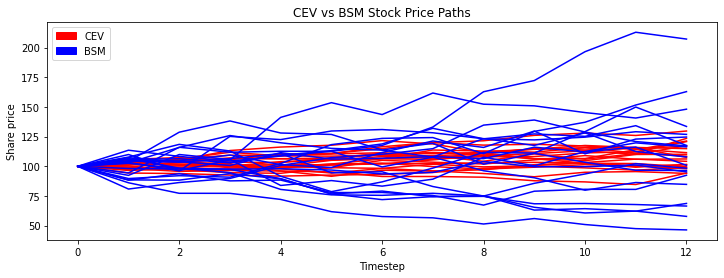

In [9]:
T = 10
sample_size = 20

share_price_path_cev = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps)
share_price_path_black_scholes = \
  generate_share_price_path(S0, r, T, sigma_const, 1.0, sample_size, timesteps, varying_vol=False)

red_patch = mpatches.Patch(color='red', label='CEV')
blue_patch = mpatches.Patch(color='blue', label='BSM')

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(share_price_path_cev, color='red')
ax.plot(share_price_path_black_scholes, color='blue')
plt.xlabel("Timestep")
plt.ylabel("Share price")
plt.legend(handles=[red_patch, blue_patch], loc='upper left')
plt.title("CEV vs BSM Stock Price Paths")
plt.show()

Next, we create a python dictionary called share_price_paths, to hold our results for part 2. The key of this dictionary would be the number of sample price paths, while the values would be the dataframes containing the price paths. We also track the rough processing time required at each step, by printing the time when each iteration completes.

In [10]:
import time

T = 1
sample_sizes = range(1000, 50001, 1000)

share_price_paths = {}

print("Start generating share price path")
start = time.time()
for sample_size in sample_sizes:
    share_val = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol=False) 
     
    share_price_paths[sample_size] = share_val
    #print("Updated for sample size {} at {}".format(sample_size, datetime.datetime.now().strftime('%H:%M')))
end = time.time()
print(f"Generating all samples paths takes {(end - start):.2f}s")

Start generating share price path
Generating all samples paths takes 1.59s


To display our output, we show the first 10 price paths generated by our iteration with 1000 samples:

In [11]:
share_price_paths[1000].iloc[:, 0:10]

,0,1,2,3,4,5,6,7,8,9
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.857562,100.106398,103.296220,103.237244,102.477151,100.141983,99.860355,99.265029,100.465829,96.664721
2,102.299627,102.170988,103.124669,106.038341,102.533543,101.845595,100.491371,99.395467,105.083317,92.029417
3,101.867161,93.865529,101.634586,104.976242,108.473032,103.778385,101.742397,94.643315,102.962963,94.429574
4,102.813675,91.982826,105.212492,102.155602,106.666274,101.342648,102.277561,97.341252,100.677285,100.997206
5,100.933753,96.627653,106.951672,104.840510,107.463153,101.973944,98.958936,98.323329,101.680525,102.179669
6,101.957430,95.208273,104.464336,106.214328,107.054801,106.243952,100.637030,103.183938,104.453154,107.263225
7,104.571916,92.148076,102.967291,106.638492,104.328094,110.008954,97.368919,107.018006,102.202276,102.605055
8,106.576893,90.127079,104.435163,106.043822,103.826505,111.997720,100.257464,106.680848,98.383468,103.449951
9,107.267472,95.636057,108.110705,108.198575,104.420906,117.704747,99.341943,108.905238,102.333938,103.678585


Next, we plot the price paths for the iteration with 1000 samples, 

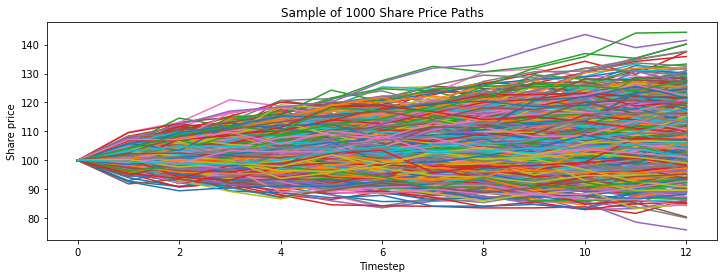

In [12]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(share_price_paths[1000])
plt.xlabel('Timestep')
plt.ylabel('Share price')
plt.title('Sample of 1000 Share Price Paths')
plt.show()

## Part 3: Monte-Carlo pricing

Using Monte Carlo, we calculate the price of the vanilla call option as follows:

In [13]:
price_estimate = []
price_std = []


for size in sample_sizes:
    S_Ts = share_price_paths[size].iloc[12, :]
    payoff = np.maximum(S_Ts - K, 0)
    discounted_price = np.exp(-r*T)*payoff
    price_estimate.append(discounted_price.mean())
    price_std.append(discounted_price.std()/np.sqrt(size))

In [14]:
print("The price estimated by Monte Carlo when using sample size of 50,000 is : {:.3f}".format(price_estimate[-1])) 

The price estimated by Monte Carlo when using sample size of 50,000 is : 8.713


### Comparison with calculation of CEV model using noncentral chi-squared distribution 

In [15]:
S0 = 100
sigma = 0.3
gamma = 0.75
r = 0.08
T = 1

In [16]:
z = 2 + 1/(1-gamma)
def C(t,K):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

In [17]:
cev_call_price = C(T, 100)

In [18]:
print("The price calculated via CEV model using noncentral chi-squared distribution is : {:.3f}".format(cev_call_price))

The price calculated via CEV model using noncentral chi-squared distribution is : 8.702


## Part 4:  Monte Carlo estimates

We plot the prices of our Monte Carlo estimates against the CEV noncentral chi-squared distribution prices calculated from Part 1 above:

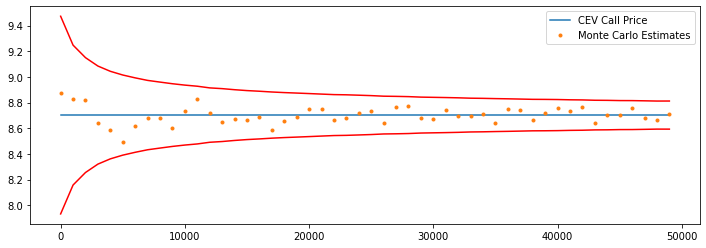

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 1000))

ax.plot([cev_call_price]*50, label='CEV Call Price')
ax.plot(price_estimate, '.', label='Monte Carlo Estimates')
ax.plot(cev_call_price + 3*np.array(price_std), 'r')
ax.plot(cev_call_price - 3*np.array(price_std), 'r')
ax.xaxis.set_major_formatter(ticks_x)
plt.legend()
plt.show()

We also plot the prices of our Monte Carlo estimates against the Fourier Call prices calculated from Part 1 above:

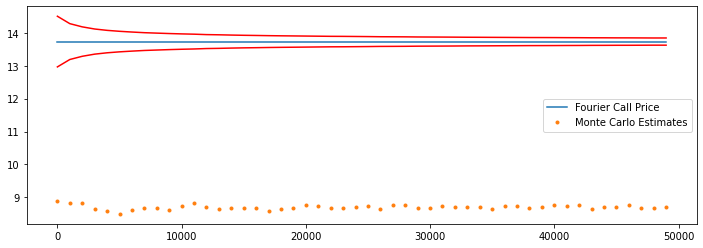

In [20]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot([fourier_call_val]*50, label='Fourier Call Price')
ax.plot(price_estimate, '.', label='Monte Carlo Estimates')
ax.plot(fourier_call_val + 3*np.array(price_std), 'r')
ax.plot(fourier_call_val - 3*np.array(price_std), 'r')
ax.xaxis.set_major_formatter(ticks_x)

plt.legend()
plt.show()

We notice that there is a discrepency. Upon further investigation, for the Heston model, ```v_0 = 0.06``` ```(v_0 = stock volatility ^ 0.5)```, so ```stock volatility = .06**0.5= 0.2449```. Note that sigma under Heston model refers to volatility of stock volatility

Under our stock price Monte Carlo calculation, the default ```stock volatility is 0.0948``` (given by  ```0.3*(100)*-.25``` ). Thus its much less than Heston. To have the same initial stock volatility, we find a new value for $\sigma$ by equating $\sigma(S_{ti})^{\gamma-1} = \sqrt{0.06}$, giving us $\sigma = 0.775$. 

We then find that our newly calculated Monte Carlo calculated call prices are aligned with the Fourier prices.

In [21]:
sigma_const = 0.775

T = 1
sample_sizes = range(1000, 50001, 1000)

share_price_paths = {}

print("Start generating share price path")
start = time.time()
for sample_size in sample_sizes:
    share_val = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol=False) 
     
    share_price_paths[sample_size] = share_val
    #print("Updated for sample size {} at {}".format(sample_size, datetime.datetime.now().strftime('%H:%M')))
end = time.time()
print(f"Generating all samples paths takes {(end - start):.2f}s")

Start generating share price path
Generating all samples paths takes 1.63s


In [22]:
price_estimate = []
price_std = []


for size in sample_sizes:
    S_Ts = share_price_paths[size].iloc[12, :]
    payoff = np.maximum(S_Ts - K, 0)
    discounted_price = np.exp(-r*T)*payoff
    price_estimate.append(discounted_price.mean())
    price_std.append(discounted_price.std()/np.sqrt(size))

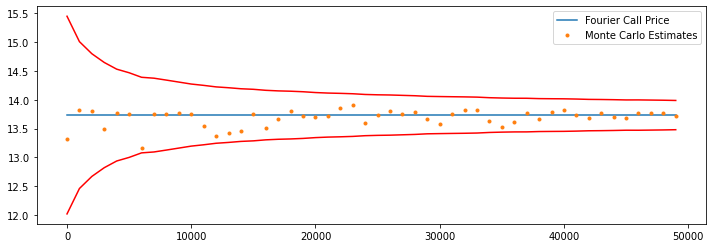

In [23]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot([fourier_call_val]*50, label='Fourier Call Price')
ax.plot(price_estimate, '.', label='Monte Carlo Estimates')
ax.plot(fourier_call_val + 3*np.array(price_std), 'r')
ax.plot(fourier_call_val - 3*np.array(price_std), 'r')
ax.xaxis.set_major_formatter(ticks_x)
plt.legend()
plt.show()

#### Conclusion
A vanilla European call option was priced for a fluctuating volatility condition, using the Heston model. The call price was evaluated as USD 13.73 which was verified to be similar to - but lower than - a constant volatility estimate using the Black-Scholes model at USD 15.71.


Initially the values calculated for the underlying share price did not agree as expected, with the estimates well outside the expected error range. This was because the volatility term was not equivalent in the two different calculation methods. After resolving this, the CEV model calcu- lated a price of USD 8.70 for the underlying share, which agreed closely with the Monte Carlo estimate of USD 8.69. This represents an absolute error of 1c and a relative discrepancy of approximately 0.1


The agreement between the results from various methods, although expected, provides confidence to choose the most suitable method for a situation with the knowledge that the results are accurate within a small margin of error.

#### References

[1] Hull, J. and White, A. (1987). The pricing of options on assets with stochastic volatilities. The journal of finance, 42(2):281–300.

[2] Stein, E. M. and Stein, J. C. (1991). Stock price distributions with stochastic volatility: an analytic approach. Review of financial Studies, 4(4):727–752.

[3] Heston, S. L. (1993). A closed-form solution for options with stochastic volatility with applications to bond and currency options. Review of financial studies, 6(2):327–343. 

[4] Heston, S. L. (1997). A simple new formula for options with stochastic volatility. 

[5] Albrecher, H., Mayer, P., Schoutens, W. and Tistaert, J. (2007). “The Little Heston Trap”, Wilmott (1): 83–92.


